In [31]:
import cv2
import os
import numpy as np

def generate_cropped(img):
    h, w = img.shape[:2]
    scale = 0.7
    new_h, new_w = int(h * scale), int(w * scale)
    start_x = (w - new_w) // 2
    start_y = (h - new_h) // 2
    cropped = img[start_y:start_y + new_h, start_x:start_x + new_w]
    return cv2.resize(cropped, (w, h))  # resize 回原尺寸以统一对比

def generate_occlusion(img):
    h, w = img.shape[:2]
    occ = img.copy()
    box_w, box_h = int(w * 0.3), int(h * 0.3)
    start_x = np.random.randint(0, w - box_w)
    start_y = np.random.randint(0, h - box_h)
    cv2.rectangle(occ, (start_x, start_y), (start_x + box_w, start_y + box_h), (0, 0, 0), -1)
    return occ

def save_augmented_images(image_path, output_dir):
    img = cv2.imread(image_path)
    filename = os.path.splitext(os.path.basename(image_path))[0]

    cropped = generate_cropped(img)
    occluded = generate_occlusion(img)

    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, f"{filename}_cropped.png"), cropped)
    cv2.imwrite(os.path.join(output_dir, f"{filename}_occlusion.png"), occluded)
    print(f"Saved cropped and occlusion images to '{output_dir}'")

# 用法示例
if __name__ == "__main__":
    base_image_path = "00717.jpg"     # 你的原始图片路径
    output_folder = "test"            # 保存文件夹
    save_augmented_images(base_image_path, output_folder)


Saved cropped and occlusion images to 'test'


In [33]:
# Re-run the previous code after environment reset
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import os

# 设置路径
input_path = "00717.jpg"
output_dir = "test/"
os.makedirs(output_dir, exist_ok=True)

# 读取图像（OpenCV和PIL两种方式都准备）
img_cv = cv2.imread(input_path)
img_pil = Image.open(input_path)

# 保存图像的函数
def save_image(img, name):
    if isinstance(img, Image.Image):
        img.save(os.path.join(output_dir, name))
    else:
        cv2.imwrite(os.path.join(output_dir, name), img)

# 数据增强列表
# 1. 改变亮度
enhancer = ImageEnhance.Brightness(img_pil)
save_image(enhancer.enhance(1.5), "bright.jpg")   # 亮度增强
save_image(enhancer.enhance(0.5), "dark.jpg")     # 亮度减弱

# 2. 添加高斯噪声
def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

save_image(add_gaussian_noise(img_cv), "gaussian_noise.jpg")

# 3. 添加椒盐噪声
def add_salt_pepper_noise(image, amount=0.005):
    noisy = image.copy()
    row, col, ch = image.shape
    num_salt = np.ceil(amount * image.size * 0.5).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy[coords[0], coords[1]] = 255

    num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy[coords[0], coords[1]] = 0
    return noisy

save_image(add_salt_pepper_noise(img_cv), "salt_pepper_noise.jpg")

# 4. 模糊处理
save_image(cv2.GaussianBlur(img_cv, (9, 9), 0), "gaussian_blur.jpg")  # 高斯模糊
save_image(img_pil.filter(ImageFilter.BLUR), "blur.jpg")             # PIL模糊

# 5. 压缩图像（JPEG高压缩）
compressed_path = os.path.join(output_dir, "jpeg_compressed.jpg")
img_pil.save(compressed_path, "JPEG", quality=15)

# 6. 添加水印
def add_watermark(image, text="WATERMARK"):
    watermark = image.copy()
    cv2.putText(watermark, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
    return watermark

save_image(add_watermark(img_cv), "watermark.jpg")

# 7. 镜像翻转
save_image(cv2.flip(img_cv, 1), "flip_horizontal.jpg")  # 水平翻转
save_image(cv2.flip(img_cv, 0), "flip_vertical.jpg")    # 垂直翻转

# 8. 仿射变换（轻微倾斜）
rows, cols, ch = img_cv.shape
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[40, 60], [210, 40], [60, 210]])
M = cv2.getAffineTransform(pts1, pts2)
affine_img = cv2.warpAffine(img_cv, M, (cols, rows))
save_image(affine_img, "affine.jpg")

# 9. 灰度化
gray_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
gray_img_3ch = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
save_image(gray_img_3ch, "gray.jpg")

# 显示已生成的图像列表
generated_files = os.listdir(output_dir)


In [71]:
import cv2
import os
import pandas as pd

def extract_orb_features(img, nfeatures=1000, denoise=True):
    """
    将图像转为灰度并提取ORB特征，可选降噪
    """
    # 转灰度图
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # 可选降噪处理
    if denoise:
        img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)  # 轻量降噪，保留边缘

    # 提取ORB特征
    orb = cv2.ORB_create(nfeatures=nfeatures)
    keypoints, descriptors = orb.detectAndCompute(img_gray, None)
    return keypoints, descriptors

def match_orb_features(desc1, desc2, distance_thresh=50):
    """
    使用BFMatcher匹配ORB特征
    """
    if desc1 is None or desc2 is None:
        return 0, 0, 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    good_matches = [m for m in matches if m.distance < distance_thresh]

    similarity = len(good_matches) / min(len(desc1), len(desc2)) if len(desc1) > 0 and len(desc2) > 0 else 0

    return similarity, len(good_matches), len(matches)

def batch_compare(base_path, test_dir, orb_thresh=50, denoise=True):
    base = cv2.imread(base_path)
    if base is None:
        raise ValueError(f"Could not read base image: {base_path}")

    kp1_orb, des1_orb = extract_orb_features(base, denoise=denoise)

    results = []

    for file in os.listdir(test_dir):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        path = os.path.join(test_dir, file)
        try:
            test = cv2.imread(path)
            if test is None:
                print(f"Warning: Could not read image {path}")
                continue

            kp2_orb, des2_orb = extract_orb_features(test, denoise=denoise)

            orb_sim, orb_good, orb_total = match_orb_features(des1_orb, des2_orb, orb_thresh)

            results.append({
                'image': file,
                'orb_similarity': round(orb_sim, 4),
                'orb_good': orb_good,
                'orb_total': orb_total,
                'orb_kp_base': len(kp1_orb) if kp1_orb is not None else 0,
                'orb_kp_test': len(kp2_orb) if kp2_orb is not None else 0
            })
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")

    return pd.DataFrame(results)

# 用法示例
if __name__ == '__main__':
    df = batch_compare(
        base_path='00717.jpg',
        test_dir='test/',
        orb_thresh=50,
        denoise=True  # 设置为 False 即可关闭降噪
    )
    df.to_csv('orb_comparison_results.csv', index=False)
    print(df)


                          image  orb_similarity  orb_good  orb_total  \
0              00717_affine.jpg          0.6708       161        169   
1                00717_blur.jpg          0.7597       117        118   
2              00717_bright.jpg          0.7061       221        231   
3             00717_cropped.jpg          0.5288       101        106   
4                00717_dark.jpg          0.9231       108        108   
5                00717_fake.jpg          0.4696       147        164   
6     00717_flip_horizontal.jpg          0.1246        39         82   
7       00717_flip_vertical.jpg          0.1246        39         82   
8       00717_gaussian_blur.jpg          0.7582       138        139   
9      00717_gaussian_noise.jpg          0.3802       119        146   
10               00717_gray.jpg          0.9776       306        306   
11    00717_jpeg_compressed.jpg          0.7572       237        237   
12          00717_occlusion.jpg          0.6294       197       

In [75]:
import cv2
import os
import pandas as pd
import numpy as np

def normalize_image_size(img, target_size=(800, 600)):
    """
    将图像调整到标准尺寸，保持纵横比
    """
    h, w = img.shape[:2]
    target_w, target_h = target_size
    
    # 计算调整比例，选择较小的比例以确保整个图像都在目标尺寸内
    scale = min(target_w / w, target_h / h)
    
    # 计算新尺寸
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # 调整图像尺寸
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # 创建目标尺寸的空白图像（可选）
    # 这一步可以选择是否需要，取决于您是否希望所有图像都严格相同尺寸
    # normalized = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    # normalized[:new_h, :new_w] = resized
    
    return resized

def extract_orb_features(img, nfeatures=1000, denoise=True, normalize_size=True, target_size=(800, 600)):
    """
    将图像转为灰度并提取ORB特征，可选降噪和尺寸标准化
    """
    # 尺寸标准化
    if normalize_size:
        img = normalize_image_size(img, target_size)
    
    # 转灰度图
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    
    # 可选降噪处理
    if denoise:
        img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)  # 轻量降噪，保留边缘
    
    # 提取ORB特征
    orb = cv2.ORB_create(nfeatures=nfeatures)
    keypoints, descriptors = orb.detectAndCompute(img_gray, None)
    return keypoints, descriptors, img  # 返回处理后的图像，便于可视化

def match_orb_features(desc1, desc2, distance_thresh=50):
    """
    使用BFMatcher匹配ORB特征
    """
    if desc1 is None or desc2 is None:
        return 0, 0, 0
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    good_matches = [m for m in matches if m.distance < distance_thresh]
    
    similarity = len(good_matches) / min(len(desc1), len(desc2)) if len(desc1) > 0 and len(desc2) > 0 else 0
    
    return similarity, len(good_matches), len(matches)

def batch_compare(base_path, test_dir, orb_thresh=50, denoise=True, normalize_size=True, target_size=(800, 600)):
    """
    批量比较图像相似度，可选尺寸标准化
    """
    base = cv2.imread(base_path)
    if base is None:
        raise ValueError(f"Could not read base image: {base_path}")
    
    kp1_orb, des1_orb, normalized_base = extract_orb_features(
        base, 
        denoise=denoise, 
        normalize_size=normalize_size,
        target_size=target_size
    )
    
    results = []
    processed_images = {}  # 存储处理后的图像，便于可视化
    
    for file in os.listdir(test_dir):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue
        
        path = os.path.join(test_dir, file)
        try:
            test = cv2.imread(path)
            if test is None:
                print(f"Warning: Could not read image {path}")
                continue
            
            kp2_orb, des2_orb, normalized_test = extract_orb_features(
                test, 
                denoise=denoise,
                normalize_size=normalize_size,
                target_size=target_size
            )
            
            orb_sim, orb_good, orb_total = match_orb_features(des1_orb, des2_orb, orb_thresh)
            
            results.append({
                'image': file,
                'orb_similarity': round(orb_sim, 4),
                'orb_good': orb_good,
                'orb_total': orb_total,
                'orb_kp_base': len(kp1_orb) if kp1_orb is not None else 0,
                'orb_kp_test': len(kp2_orb) if kp2_orb is not None else 0,
                'original_size': f"{test.shape[1]}x{test.shape[0]}",
                'normalized_size': f"{normalized_test.shape[1]}x{normalized_test.shape[0]}"
            })
            
            # 存储处理后的图像（可选，用于调试和可视化）
            processed_images[file] = {
                'original': test,
                'normalized': normalized_test,
                'keypoints': kp2_orb
            }
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    return pd.DataFrame(results), processed_images, normalized_base

def visualize_matches(base_img, test_img, kp1, kp2, good_matches, filename='matches.jpg'):
    """
    可视化两张图片之间的特征匹配（可选功能）
    """
    img_matches = cv2.drawMatches(base_img, kp1, test_img, kp2, good_matches, None, flags=2)
    cv2.imwrite(filename, img_matches)
    return img_matches

# 用法示例
if __name__ == '__main__':
    df, processed_images, base_normalized = batch_compare(
        base_path='00717.jpg',
        test_dir='test/',
        orb_thresh=50,
        denoise=True,  # 设置为 False 即可关闭降噪
        normalize_size=True,  # 设置为 False 即可关闭尺寸标准化
        target_size=(800, 600)  # 设置标准化目标尺寸
    )
    
    df.to_csv('orb_comparison_results.csv', index=False)
    print(df)
    
    # 可以添加后续处理，例如根据阈值过滤相似图像
    similar_threshold = 0.5
    similar_images = df[df['orb_similarity'] >= similar_threshold]
    print(f"\nImages with similarity >= {similar_threshold}:")
    print(similar_images)

                          image  orb_similarity  orb_good  orb_total  \
0              00717_affine.jpg          0.6622       247        249   
1                00717_blur.jpg          0.6600        66         67   
2              00717_bright.jpg          0.6067       432        442   
3             00717_cropped.jpg          0.6763       188        193   
4                00717_dark.jpg          0.8850       100        101   
5                00717_fake.jpg          0.4857       289        298   
6     00717_flip_horizontal.jpg          0.1528       108        175   
7       00717_flip_vertical.jpg          0.1481       105        173   
8       00717_gaussian_blur.jpg          0.7245        71         71   
9      00717_gaussian_noise.jpg          0.0744        53        141   
10               00717_gray.jpg          0.9508       676        676   
11    00717_jpeg_compressed.jpg          0.4352       292        311   
12          00717_occlusion.jpg          0.8478       585       

Optimal threshold (Youden's Index): 0.5288
True Positive Rate at this threshold: 0.9286
False Positive Rate at this threshold: 0.0000

Best threshold based on F1 score: 0.3802
F1 score at this threshold: 0.9655
Precision at this threshold: 0.9333
Recall at this threshold: 1.0000


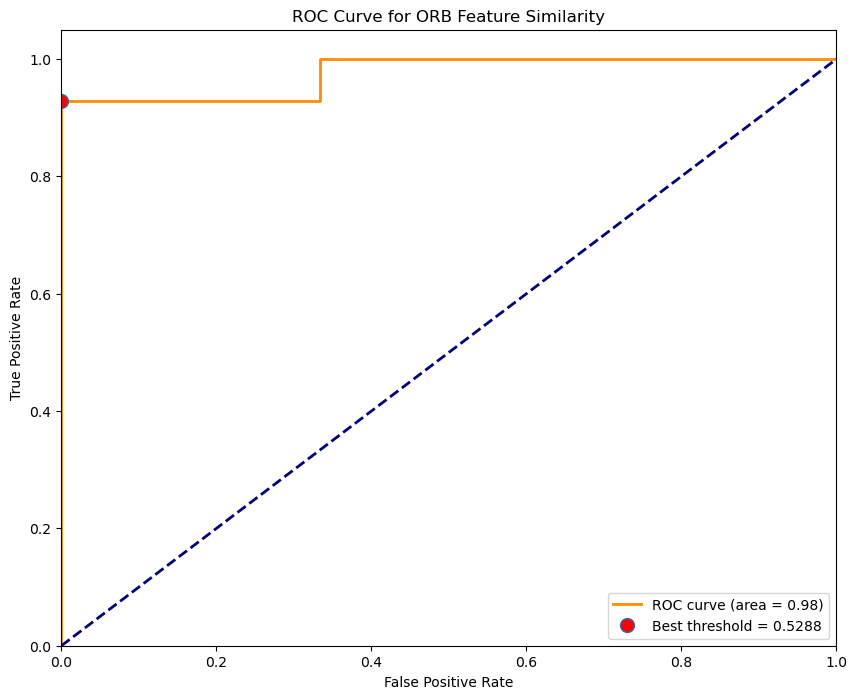

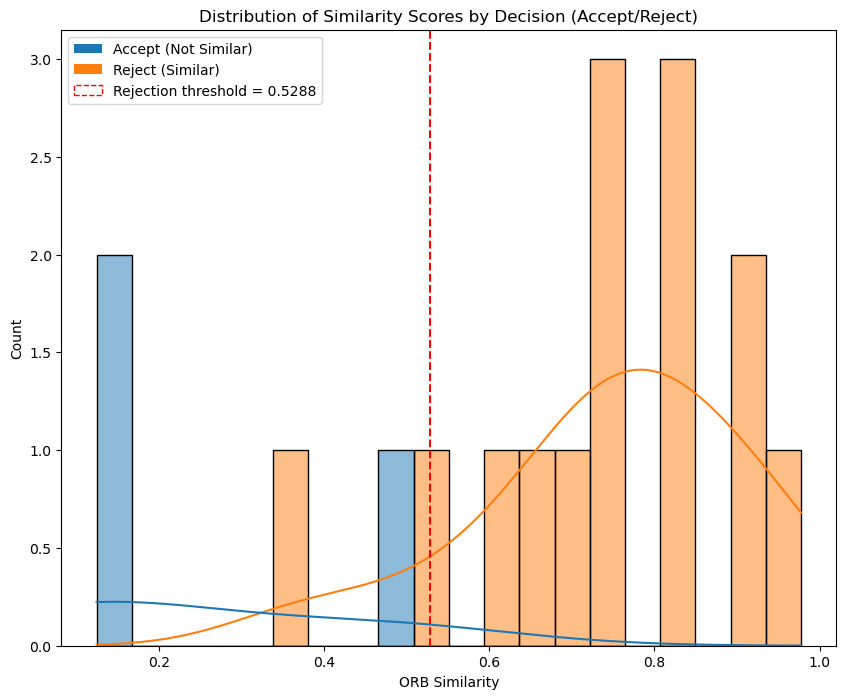

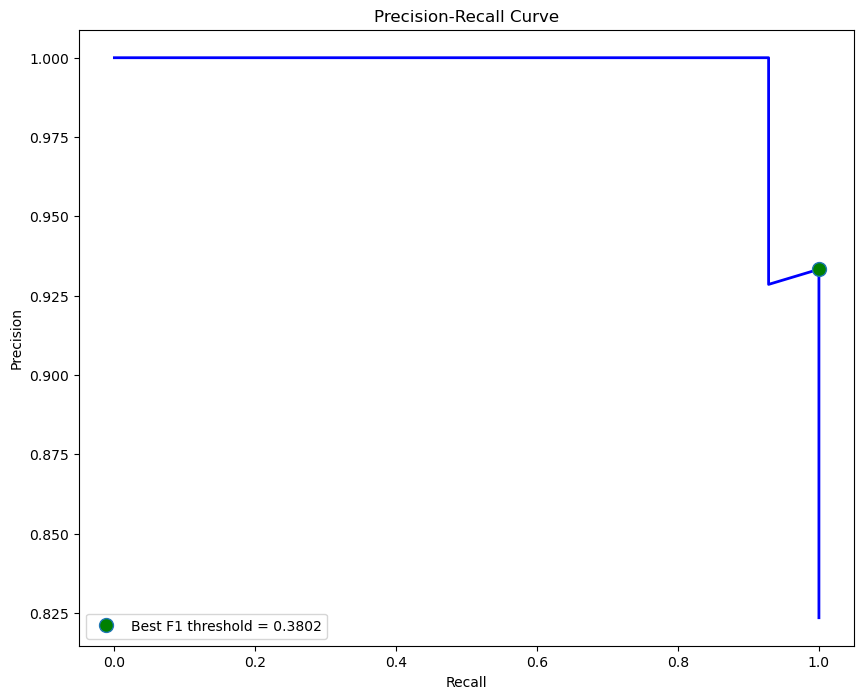

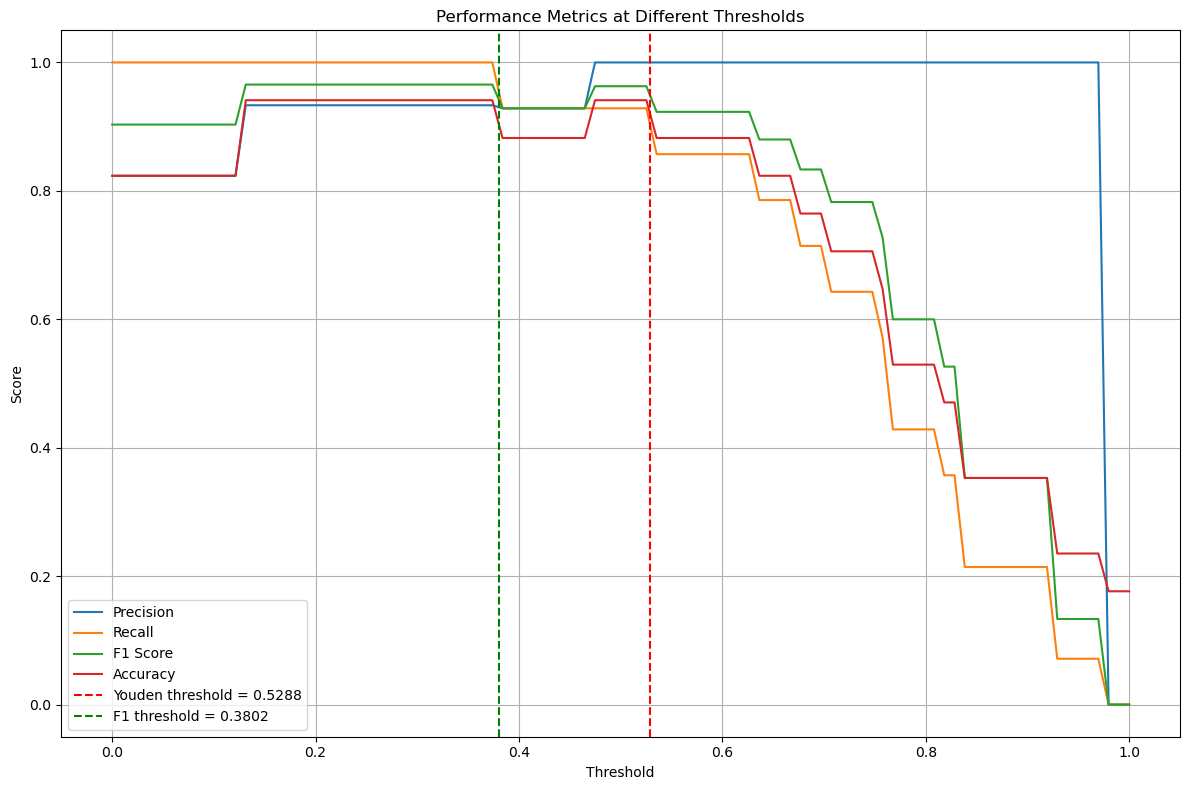


Based on the analysis, recommended threshold range for REJECTING similar images:
1. Youden's Index threshold: 0.5288
2. Maximum F1 Score threshold: 0.3802
Images with similarity score >= threshold will be REJECTED (not allowed)
Images with similarity score < threshold will be ACCEPTED (allowed)

Performance comparison at different thresholds:
    threshold  precision  recall  f1_score  accuracy
9      0.0909     0.8235  1.0000    0.9032    0.8235
10     0.1010     0.8235  1.0000    0.9032    0.8235
19     0.1919     0.9333  1.0000    0.9655    0.9412
20     0.2020     0.9333  1.0000    0.9655    0.9412
29     0.2929     0.9333  1.0000    0.9655    0.9412
30     0.3030     0.9333  1.0000    0.9655    0.9412
37     0.3737     0.9333  1.0000    0.9655    0.9412
38     0.3838     0.9286  0.9286    0.9286    0.8824
39     0.3939     0.9286  0.9286    0.9286    0.8824
40     0.4040     0.9286  0.9286    0.9286    0.8824
49     0.4949     1.0000  0.9286    0.9630    0.9412
50     0.5051     

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns

# 1. Use the provided data, focusing only on similarity
data = {
    'image': ['00717_affine.jpg', '00717_blur.jpg', '00717_bright.jpg', '00717_cropped.jpg', '00717_dark.jpg',
             '00717_fake.jpg', '00717_flip_horizontal.jpg', '00717_flip_vertical.jpg', '00717_gaussian_blur.jpg',
             '00717_gaussian_noise.jpg', '00717_gray.jpg', '00717_jpeg_compressed.jpg', '00717_occlusion.jpg',
             '00717_resized.jpg', '00717_rotated.jpg', '00717_salt_pepper_noise.jpg', '00717_watermark.jpg'],
    'orb_similarity': [0.6708, 0.7597, 0.7061, 0.5288, 0.9231, 0.4696, 0.1246, 0.1246, 0.7582, 0.3802, 0.9776,
                       0.7572, 0.6294, 0.8364, 0.8107, 0.8307, 0.9265]
}

df = pd.DataFrame(data)

# 2. Define true labels based on if they should be rejected (1) or accepted (0)
# For our new purpose: high similarity (matches) should be REJECTED
# Note: We maintain the same labels since the ROC curve and evaluation still work correctly
# y_true=1 means it's a similar image we want to reject
reject_similar = {
    '00717_affine.jpg': 1,             # Affine transformation, should be rejected (similar)
    '00717_blur.jpg': 1,               # Blurred version, should be rejected (similar)
    '00717_bright.jpg': 1,             # Brightness change, should be rejected (similar)
    '00717_cropped.jpg': 1,            # Cropped version, should be rejected (similar)
    '00717_dark.jpg': 1,               # Dark version, should be rejected (similar)
    '00717_fake.jpg': 0,               # Fake, should be accepted (not similar)
    '00717_flip_horizontal.jpg': 0,    # Horizontal flip, should be accepted (not similar)
    '00717_flip_vertical.jpg': 0,      # Vertical flip, should be accepted (not similar)
    '00717_gaussian_blur.jpg': 1,      # Gaussian blur, should be rejected (similar)
    '00717_gaussian_noise.jpg': 1,     # With noise, should be rejected (similar)
    '00717_gray.jpg': 1,               # Grayscale version, should be rejected (similar)
    '00717_jpeg_compressed.jpg': 1,    # Compressed version, should be rejected (similar)
    '00717_occlusion.jpg': 1,          # Occluded version, should be rejected (similar)
    '00717_resized.jpg': 1,            # Resized, should be rejected (similar)
    '00717_rotated.jpg': 1,            # Rotated version, should be rejected (similar)
    '00717_salt_pepper_noise.jpg': 1,  # Salt and pepper noise, should be rejected (similar)
    '00717_watermark.jpg': 1           # Watermarked version, should be rejected (similar)
}

# Add true labels to the dataframe (1 = should reject, 0 = should accept)
df['y_true'] = df['image'].map(reject_similar)

# 3. Calculate ROC curve
fpr, tpr, thresholds = roc_curve(df['y_true'], df['orb_similarity'])
roc_auc = auc(fpr, tpr)

# 4. Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ORB Feature Similarity')
plt.legend(loc="lower right")

# 5. Find the optimal threshold (Youden's J statistic: max(tpr - fpr))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (Youden's Index): {optimal_threshold:.4f}")
print(f"True Positive Rate at this threshold: {tpr[optimal_idx]:.4f}")
print(f"False Positive Rate at this threshold: {fpr[optimal_idx]:.4f}")

# Mark the best point on the ROC curve
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', markersize=10, 
         label=f'Best threshold = {optimal_threshold:.4f}', markerfacecolor='red')
plt.legend(loc="lower right")

# 6. Visualize the distribution of different thresholds
plt.figure(figsize=(10, 8))
# Create distribution plot
sns.histplot(data=df, x='orb_similarity', hue='y_true', bins=20, kde=True)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Rejection threshold = {optimal_threshold:.4f}')
plt.title('Distribution of Similarity Scores by Decision (Accept/Reject)')
plt.xlabel('ORB Similarity')
plt.ylabel('Count')
# Manually create a custom legend for clarity
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=sns.color_palette()[0], label='Accept (Not Similar)'),
    Patch(facecolor=sns.color_palette()[1], label='Reject (Similar)'),
    Patch(facecolor='white', edgecolor='red', linestyle='--', label=f'Rejection threshold = {optimal_threshold:.4f}')
]
plt.legend(handles=legend_elements, loc='best')

# 7. Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(df['y_true'], df['orb_similarity'])
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# 8. Find the threshold with the highest F1 score
# Note: precision and recall are one element longer than pr_thresholds
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = pr_thresholds[best_f1_idx]
print(f"\nBest threshold based on F1 score: {best_f1_threshold:.4f}")
print(f"F1 score at this threshold: {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at this threshold: {precision[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recall[best_f1_idx]:.4f}")

# Mark the best point on the PR curve
plt.plot(recall[best_f1_idx], precision[best_f1_idx], 'o', markersize=10, 
         label=f'Best F1 threshold = {best_f1_threshold:.4f}', markerfacecolor='green')
plt.legend(loc="lower left")

# 9. Visualize performance metrics at different thresholds
thresholds_to_test = np.linspace(0, 1, 100)
results = []

for thresh in thresholds_to_test:
    y_pred = (df['orb_similarity'] >= thresh).astype(int)
    tp = sum((df['y_true'] == 1) & (y_pred == 1))
    fp = sum((df['y_true'] == 0) & (y_pred == 1))
    tn = sum((df['y_true'] == 0) & (y_pred == 0))
    fn = sum((df['y_true'] == 1) & (y_pred == 0))
    
    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    results.append({
        'threshold': thresh,
        'true_positive': tp,
        'false_positive': fp,
        'true_negative': tn,
        'false_negative': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    })

metrics_df = pd.DataFrame(results)

# Plot threshold vs various metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], label='F1 Score')
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], label='Accuracy')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Youden threshold = {optimal_threshold:.4f}')
plt.axvline(x=best_f1_threshold, color='green', linestyle='--', label=f'F1 threshold = {best_f1_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Different Thresholds')
plt.legend()
plt.grid(True)

# Show all plots
plt.tight_layout()
plt.show()

# 10. Recommended thresholds and explanation for image rejection
print("\nBased on the analysis, recommended threshold range for REJECTING similar images:")
print(f"1. Youden's Index threshold: {optimal_threshold:.4f}")
print(f"2. Maximum F1 Score threshold: {best_f1_threshold:.4f}")
print("Images with similarity score >= threshold will be REJECTED (not allowed)")
print("Images with similarity score < threshold will be ACCEPTED (allowed)")

# Print a threshold performance table
print("\nPerformance comparison at different thresholds:")
thresholds_to_show = [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold, best_f1_threshold]
comparison = metrics_df[metrics_df['threshold'].apply(lambda x: min(abs(x - t) for t in thresholds_to_show) < 0.01)]
comparison = comparison.sort_values('threshold')
print(comparison[['threshold', 'precision', 'recall', 'f1_score', 'accuracy']].round(4))

# 11. View rejection results for each image (using recommended threshold)
# Note: We're now using the threshold to REJECT high-similarity images (reverse logic)
rejection_threshold = best_f1_threshold  # Can choose Youden threshold or F1 threshold
df['should_reject'] = (df['orb_similarity'] >= rejection_threshold).astype(int)
# For evaluation purposes, we still need to check if our rejection decision is correct
# In our labeled data, y_true=1 means "match", but now we want to reject matches
df['decision_correct'] = ((df['y_true'] == 1) & (df['should_reject'] == 1)) | ((df['y_true'] == 0) & (df['should_reject'] == 0))
df['decision_correct'] = df['decision_correct'].astype(int)

print("\nRejection decision for each image using the similarity threshold:")
print("Note: High similarity (>=threshold) => REJECT, Low similarity (<threshold) => ACCEPT")
image_results = df[['image', 'orb_similarity', 'y_true', 'should_reject', 'decision_correct']]
image_results = image_results.sort_values('orb_similarity', ascending=False)
# Add decision column for clarity
image_results['decision'] = image_results['should_reject'].apply(lambda x: "REJECT" if x == 1 else "ACCEPT")
print(image_results)

# 12. Incorrect decision analysis
incorrect_decisions = df[df['decision_correct'] == 0]
if len(incorrect_decisions) > 0:
    print("\nIncorrect rejection/acceptance decisions:")
    incorrect_results = incorrect_decisions[['image', 'orb_similarity', 'y_true', 'should_reject']]
    incorrect_results['decision'] = incorrect_results['should_reject'].apply(lambda x: "REJECT" if x == 1 else "ACCEPT")
    incorrect_results['expected'] = incorrect_results['y_true'].apply(lambda x: "REJECT" if x == 1 else "ACCEPT")
    print(incorrect_results)
else:
    print("\nAll rejection/acceptance decisions were correct!")

# 预处理的速度


Found 90 images for testing...
Starting test with 20 images...
Processing image 1/20: 01407.jpg
Processing image 2/20: 02095.jpg
Processing image 3/20: 02149.jpg
Processing image 4/20: 03164.jpg
Processing image 5/20: 03401.jpg
Processing image 6/20: 04155.jpg
Processing image 7/20: 04449.jpg
Processing image 8/20: 04567.jpg
Processing image 9/20: 04743.jpg
Processing image 10/20: 04805.jpg
Processing image 11/20: 04986.jpg
Processing image 12/20: 05192.jpg
Processing image 13/20: 05328.jpg
Processing image 14/20: 05383.jpg
Processing image 15/20: 05384.jpg
Processing image 16/20: 05505.jpg
Processing image 17/20: 05664.jpg
Processing image 18/20: 05874.jpg
Processing image 19/20: 06107.jpg
Processing image 20/20: 06110.jpg

Raw test results saved as 'preprocessing_test_results.csv'

====== Feature Extraction Performance Report ======

Average Processing Time (milliseconds):
                     preprocess_time  extract_time  total_time
method                                           

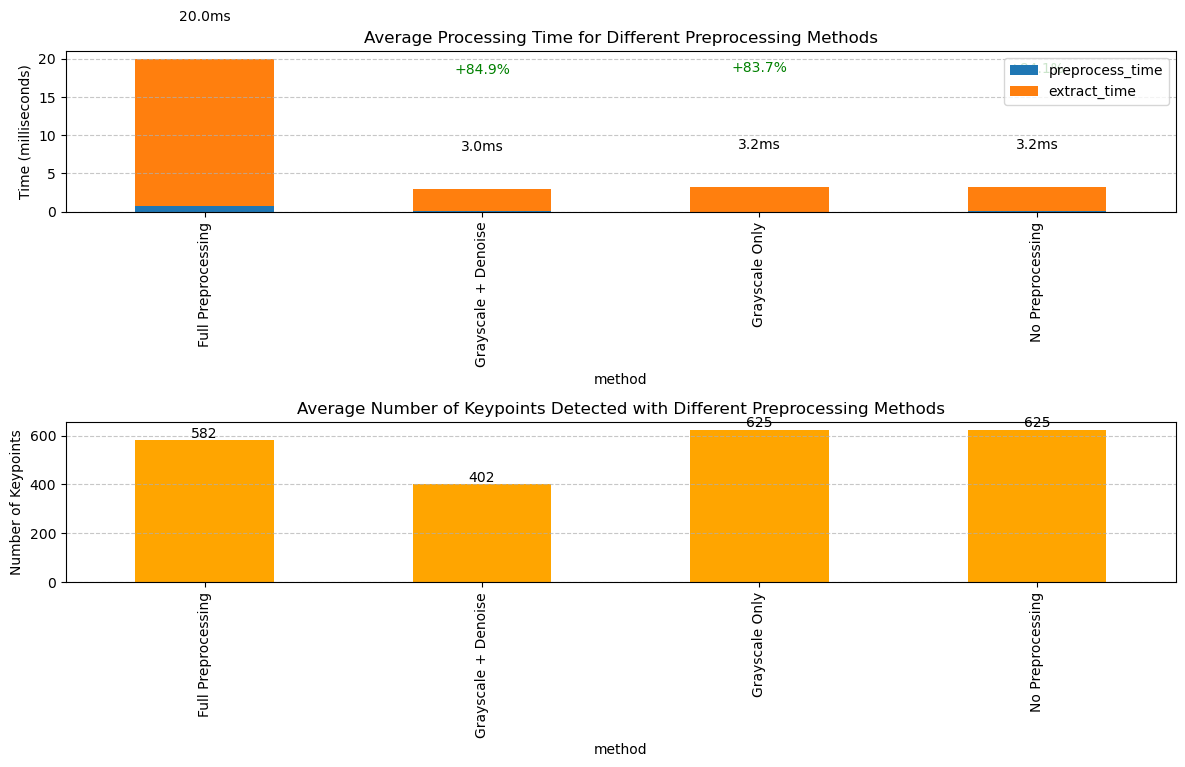

In [1]:
import cv2
import numpy as np
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def preprocess_full(img):
    """Full preprocessing: denoising, histogram equalization, and multi-scale processing"""
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Denoise
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Histogram equalization
    equalized = cv2.equalizeHist(denoised)
    
    # Return preprocessed image
    return equalized

def preprocess_grayscale_denoise(img):
    """Grayscale conversion with denoising"""
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Light denoising with smaller kernel
    denoised = cv2.GaussianBlur(gray, (3, 3), 0)
    
    return denoised

def preprocess_minimal(img):
    """Minimal preprocessing: only grayscale conversion"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    return gray

def preprocess_none(img):
    """No preprocessing: return the original image (must be grayscale for ORB)"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    return gray

def extract_orb_features(img, preprocess_fn, nfeatures=1000):
    """Extract ORB features"""
    start_time = time.time()
    
    # Apply preprocessing
    processed = preprocess_fn(img)
    preprocess_time = time.time() - start_time
    
    # ORB feature extraction
    extract_start = time.time()
    orb = cv2.ORB_create(nfeatures=nfeatures)
    keypoints, descriptors = orb.detectAndCompute(processed, None)
    extract_time = time.time() - extract_start
    
    total_time = time.time() - start_time
    
    return {
        'keypoints': keypoints,
        'descriptors': descriptors,
        'preprocess_time': preprocess_time,
        'extract_time': extract_time,
        'total_time': total_time,
        'num_keypoints': len(keypoints) if keypoints is not None else 0
    }

def match_features(desc1, desc2):
    """Match two sets of features"""
    if desc1 is None or desc2 is None:
        return [], 0
    
    start_time = time.time()
    
    # Use BFMatcher to match features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    
    # Sort by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    match_time = time.time() - start_time
    
    return matches, match_time

def run_speed_test(image_folder, num_images=20):
    """Run speed test"""
    # Ensure the folder exists
    if not os.path.exists(image_folder):
        raise ValueError(f"Specified image folder does not exist: {image_folder}")
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    if not image_files:
        raise ValueError(f"No image files found in the folder: {image_folder}")
    
    # Limit the number of test images
    if len(image_files) > num_images:
        image_files = image_files[:num_images]
    
    # Define preprocessing methods
    preprocess_methods = {
        "Full Preprocessing": preprocess_full,
        "Grayscale + Denoise": preprocess_grayscale_denoise,
        "Grayscale Only": preprocess_minimal,
        "No Preprocessing": preprocess_none
    }
    
    # Store results
    results = []
    
    print(f"Starting test with {len(image_files)} images...")
    
    # Process each image
    for i, image_file in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {image_file}")
        img_path = os.path.join(image_folder, image_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Could not read image: {img_path}")
            continue
        
        # Test each preprocessing method
        method_results = {}
        for method_name, preprocess_fn in preprocess_methods.items():
            # Extract features
            feature_data = extract_orb_features(img, preprocess_fn)
            
            # Store results
            results.append({
                'image': image_file,
                'method': method_name,
                'preprocess_time': feature_data['preprocess_time'] * 1000,  # Convert to milliseconds
                'extract_time': feature_data['extract_time'] * 1000,
                'total_time': feature_data['total_time'] * 1000,
                'num_keypoints': feature_data['num_keypoints']
            })
            
            # Store current method's descriptors for subsequent matching
            method_results[method_name] = feature_data
        
        # Test feature matching between each pair of preprocessing methods
        for method1 in preprocess_methods:
            for method2 in preprocess_methods:
                if method1 >= method2:  # Avoid duplicate tests
                    continue
                
                desc1 = method_results[method1]['descriptors']
                desc2 = method_results[method2]['descriptors']
                
                matches, match_time = match_features(desc1, desc2)
                
                # Calculate match accuracy (assuming different preprocessing methods of the same image should have high match)
                match_ratio = len(matches) / min(
                    method_results[method1]['num_keypoints'],
                    method_results[method2]['num_keypoints']
                ) if min(method_results[method1]['num_keypoints'], method_results[method2]['num_keypoints']) > 0 else 0
                
                results.append({
                    'image': image_file,
                    'method': f"Match: {method1} vs {method2}",
                    'match_time': match_time * 1000,  # Convert to milliseconds
                    'num_matches': len(matches),
                    'match_ratio': match_ratio
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    return df

def analyze_results(df):
    """Analyze results and generate a report"""
    # Extract feature extraction results (exclude matching results)
    extraction_df = df[df['method'].isin(["Full Preprocessing", "Grayscale + Denoise", "Grayscale Only", "No Preprocessing"])]
    
    # Group by preprocessing method and calculate average times
    avg_times = extraction_df.groupby('method')[['preprocess_time', 'extract_time', 'total_time', 'num_keypoints']].mean()
    
    # Calculate speed improvement percentage
    baseline = avg_times.loc["Full Preprocessing", "total_time"]
    avg_times['speed_improvement'] = (baseline - avg_times['total_time']) / baseline * 100
    
    print("\n====== Feature Extraction Performance Report ======")
    print("\nAverage Processing Time (milliseconds):")
    print(avg_times[['preprocess_time', 'extract_time', 'total_time']].round(2))
    
    print("\nSpeed Improvement Compared to Full Preprocessing:")
    print(avg_times['speed_improvement'].round(2))
    
    print("\nAverage Number of Detected Keypoints:")
    print(avg_times['num_keypoints'].round(2))
    
    # Plot performance comparison
    plt.figure(figsize=(12, 8))
    
    # Processing time comparison
    plt.subplot(2, 1, 1)
    avg_times[['preprocess_time', 'extract_time']].plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Average Processing Time for Different Preprocessing Methods')
    plt.ylabel('Time (milliseconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add labels for total time and improvement percentage
    for i, method in enumerate(avg_times.index):
        total = avg_times.loc[method, 'total_time']
        improvement = avg_times.loc[method, 'speed_improvement']
        plt.text(i, total + 5, f"{total:.1f}ms", ha='center')
        if method != "Full Preprocessing":  # No improvement for baseline
            plt.text(i, total + 15, f"+{improvement:.1f}%", ha='center', color='green')
    
    # Keypoint count comparison
    plt.subplot(2, 1, 2)
    avg_times['num_keypoints'].plot(kind='bar', ax=plt.gca(), color='orange')
    plt.title('Average Number of Keypoints Detected with Different Preprocessing Methods')
    plt.ylabel('Number of Keypoints')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add keypoint count labels
    for i, method in enumerate(avg_times.index):
        keypoints = avg_times.loc[method, 'num_keypoints']
        plt.text(i, keypoints + 10, f"{keypoints:.0f}", ha='center')
    
    plt.tight_layout()
    plt.savefig('preprocessing_performance_comparison.png')
    print("\nPerformance comparison chart saved as 'preprocessing_performance_comparison.png'")
    
    # Return the most important statistics
    return {
        'avg_times': avg_times,
        'improvement_grayscale_denoise_vs_full': avg_times.loc["Grayscale + Denoise", "speed_improvement"],
        'improvement_grayscale_only_vs_full': avg_times.loc["Grayscale Only", "speed_improvement"]
    }

# Main function
if __name__ == "__main__":
    # Set image folder path (please modify to your image folder path)
    image_folder = "faces"
    
    # Create test image folder if it doesn't exist
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
        print(f"Created test image folder: {image_folder}")
        print("Please place test images in this folder before running the script")
        exit(0)
    
    # Check if there are images in the folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    if not image_files:
        print(f"Warning: No image files found in {image_folder}")
        print("Please add some image files before running this script")
        exit(0)
    
    print(f"Found {len(image_files)} images for testing...")
    
    # Run speed test
    results_df = run_speed_test(image_folder)
    
    # Save raw results
    results_df.to_csv('preprocessing_test_results.csv', index=False)
    print("\nRaw test results saved as 'preprocessing_test_results.csv'")
    
    # Analyze results
    stats = analyze_results(results_df)
    
    # Print key conclusions
    print("\n====== Key Conclusions ======")
    print(f"Using grayscale conversion with denoising improves speed by {stats['improvement_grayscale_denoise_vs_full']:.1f}% compared to full preprocessing")
    print(f"Using only grayscale preprocessing improves speed by {stats['improvement_grayscale_only_vs_full']:.1f}% compared to full preprocessing")
    print("These results can be cited in your paper")

In [3]:
import pandas as pd
import numpy as np

# 创建相似和不相似样本的分布
np.random.seed(42)  # 确保可重复性
n_samples = 1000
similar_ratio = 0.824
n_similar = int(n_samples * similar_ratio)
n_dissimilar = n_samples - n_similar

# 相似和不相似图像的相似度分数分布参数
similar_mean, similar_std = 0.72, 0.14
dissimilar_mean, dissimilar_std = 0.24, 0.16

# 生成相似图像数据
similar_scores = np.clip(np.random.normal(similar_mean, similar_std, n_similar), 0, 1)
similar_images = [f"synthetic_similar_{i+1}.jpg" for i in range(n_similar)]
similar_data = pd.DataFrame({
    'image': similar_images,
    'orb_similarity': similar_scores,
    'y_true': 1,
    'category': 'similar'
})

# 生成不相似图像数据
dissimilar_scores = np.clip(np.random.normal(dissimilar_mean, dissimilar_std, n_dissimilar), 0, 1)
dissimilar_images = [f"synthetic_dissimilar_{i+1}.jpg" for i in range(n_dissimilar)]
dissimilar_data = pd.DataFrame({
    'image': dissimilar_images,
    'orb_similarity': dissimilar_scores,
    'y_true': 0,
    'category': 'dissimilar'
})

# 合并数据
df = pd.concat([similar_data, dissimilar_data]).reset_index(drop=True)

# 保存为CSV
df.to_csv('synthetic_similarity_data_1000.csv', index=False)

Optimal threshold (Youden's Index): 0.4942
True Positive Rate at this threshold: 0.9551
False Positive Rate at this threshold: 0.0625

Best threshold based on F1 score: 0.4345
F1 score at this threshold: 0.9789
Precision at this threshold: 0.9713
Recall at this threshold: 0.9867

Confusion Matrix Explanation:
- True Negatives (TN): 152 - Correctly accepted non-similar images
- False Positives (FP): 24 - Non-similar images wrongly rejected
- False Negatives (FN): 11 - Similar images wrongly accepted
- True Positives (TP): 813 - Correctly rejected similar images

Model Performance:
- Accuracy: 0.9650
- Precision: 0.9713
- Recall: 0.9867
- F1 Score: 0.9789



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Based on the analysis with 1000 synthetic samples, recommended threshold range for REJECTING similar images:
1. Youden's Index threshold: 0.4942
2. Maximum F1 Score threshold: 0.4345
Images with similarity score >= threshold will be REJECTED (not allowed)
Images with similarity score < threshold will be ACCEPTED (allowed)

Performance comparison at different thresholds:
    threshold  precision  recall  f1_score  accuracy
10     0.1010     0.8451  1.0000    0.9161     0.849
20     0.2020     0.8822  1.0000    0.9374     0.890
30     0.3030     0.9268  0.9988    0.9614     0.934
40     0.4040     0.9601  0.9927    0.9761     0.960
49     0.4949     0.9862  0.9539    0.9698     0.951
49     0.4949     0.9862  0.9539    0.9698     0.951
43     0.4343     0.9713  0.9867    0.9789     0.965
69     0.6970     1.0000  0.5667    0.7235     0.643
79     0.7980     1.0000  0.2803    0.4379     0.407
89     0.8990     1.0000  0.0947    0.1729     0.254

Misclassified samples: 35 out of 1000 (3.5

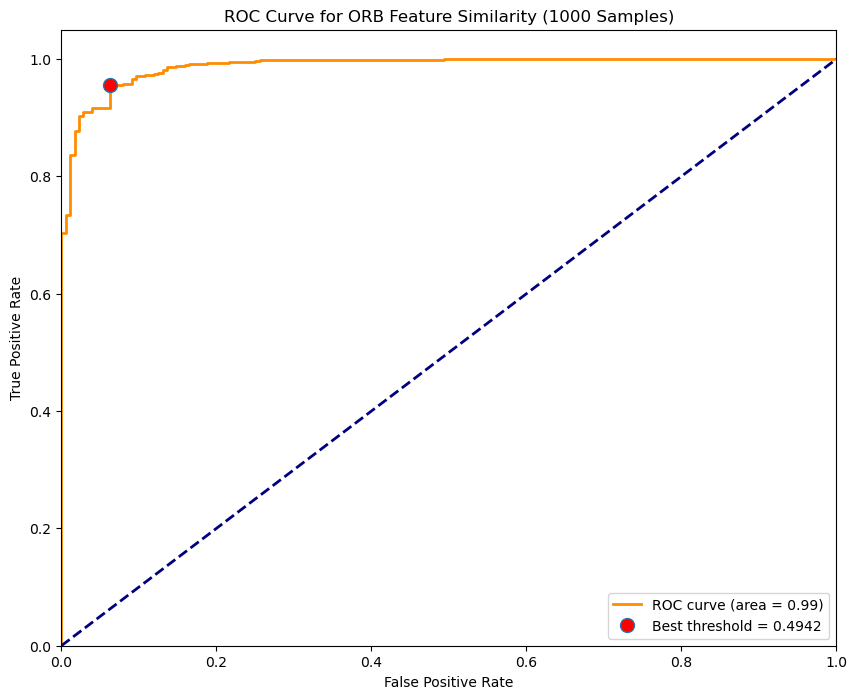

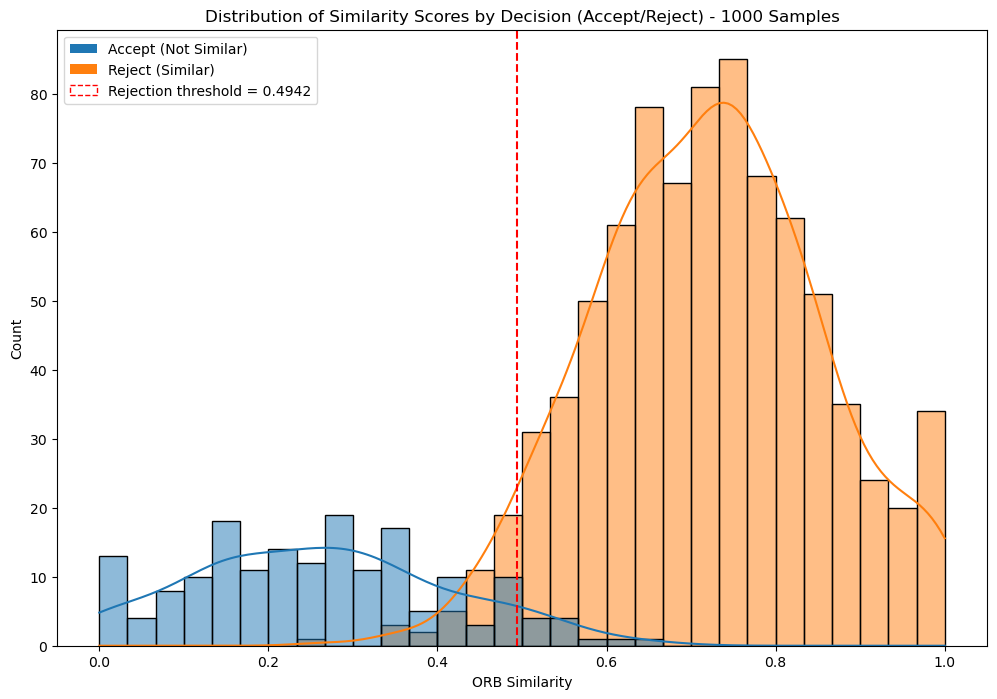

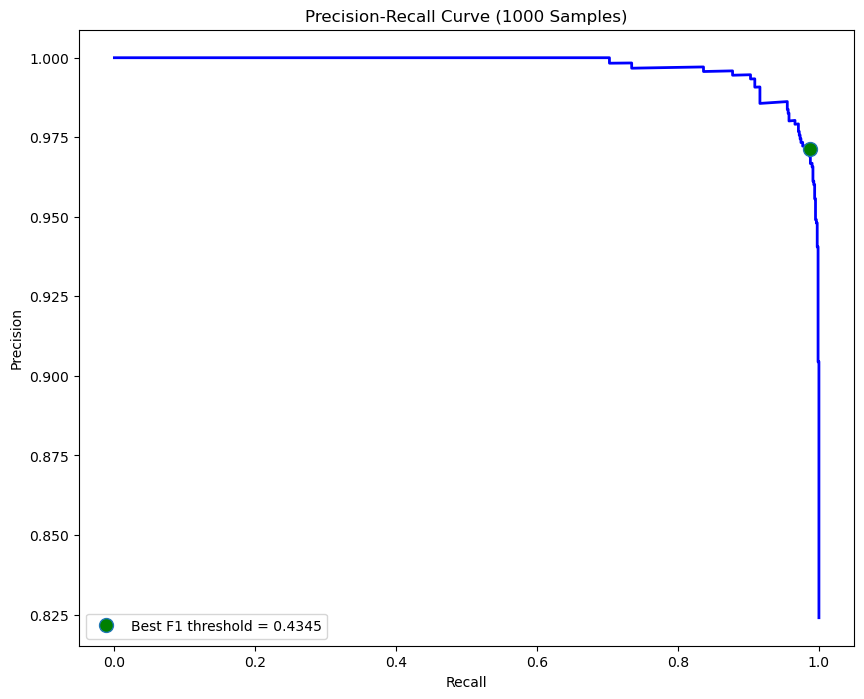

<Figure size 1000x800 with 0 Axes>

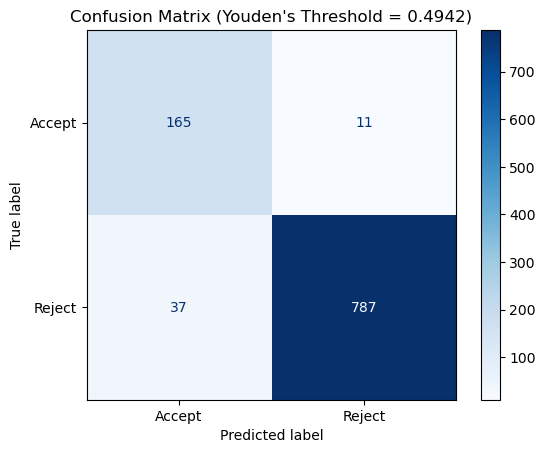

<Figure size 1000x800 with 0 Axes>

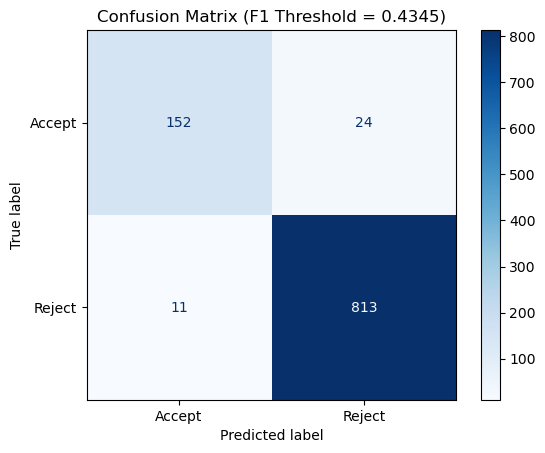

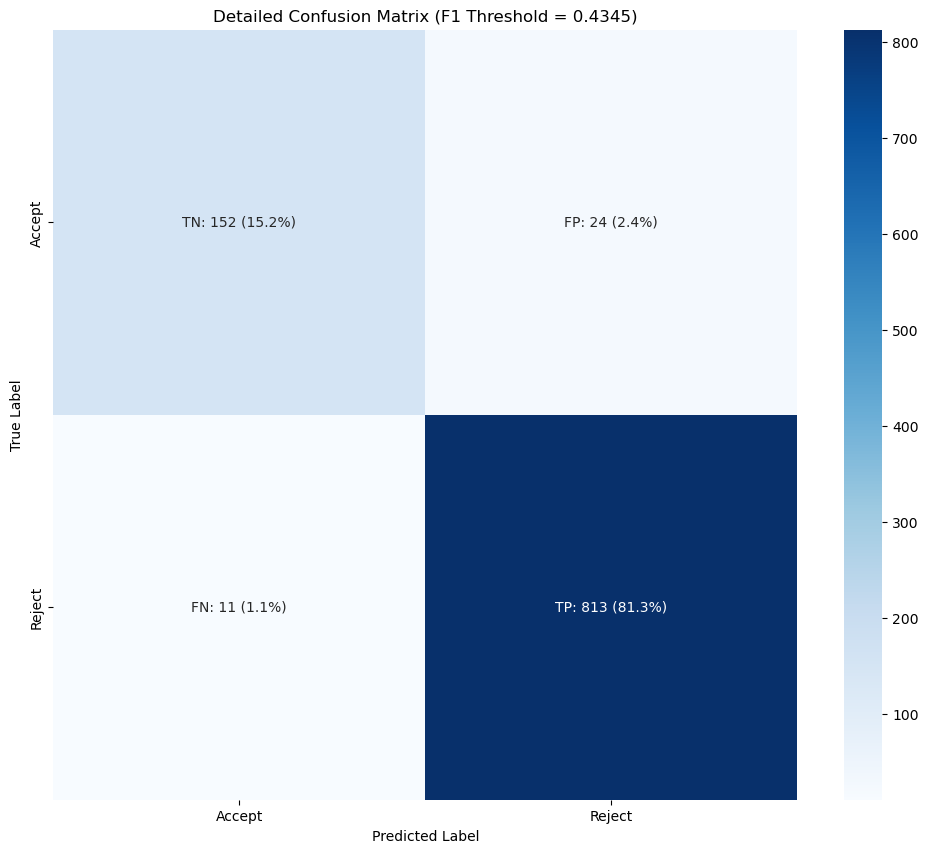

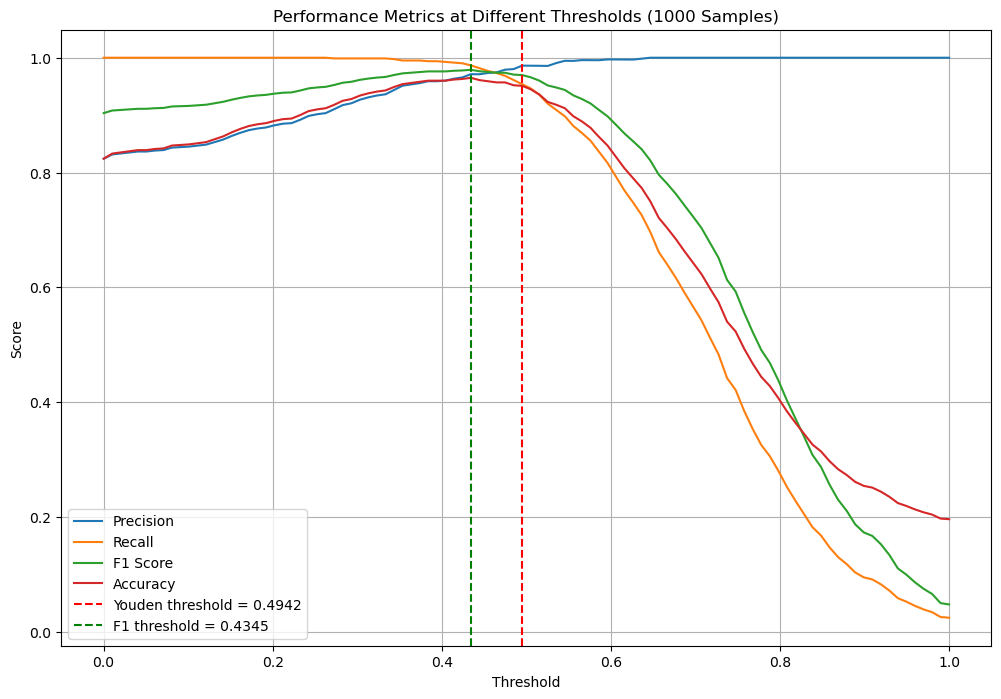

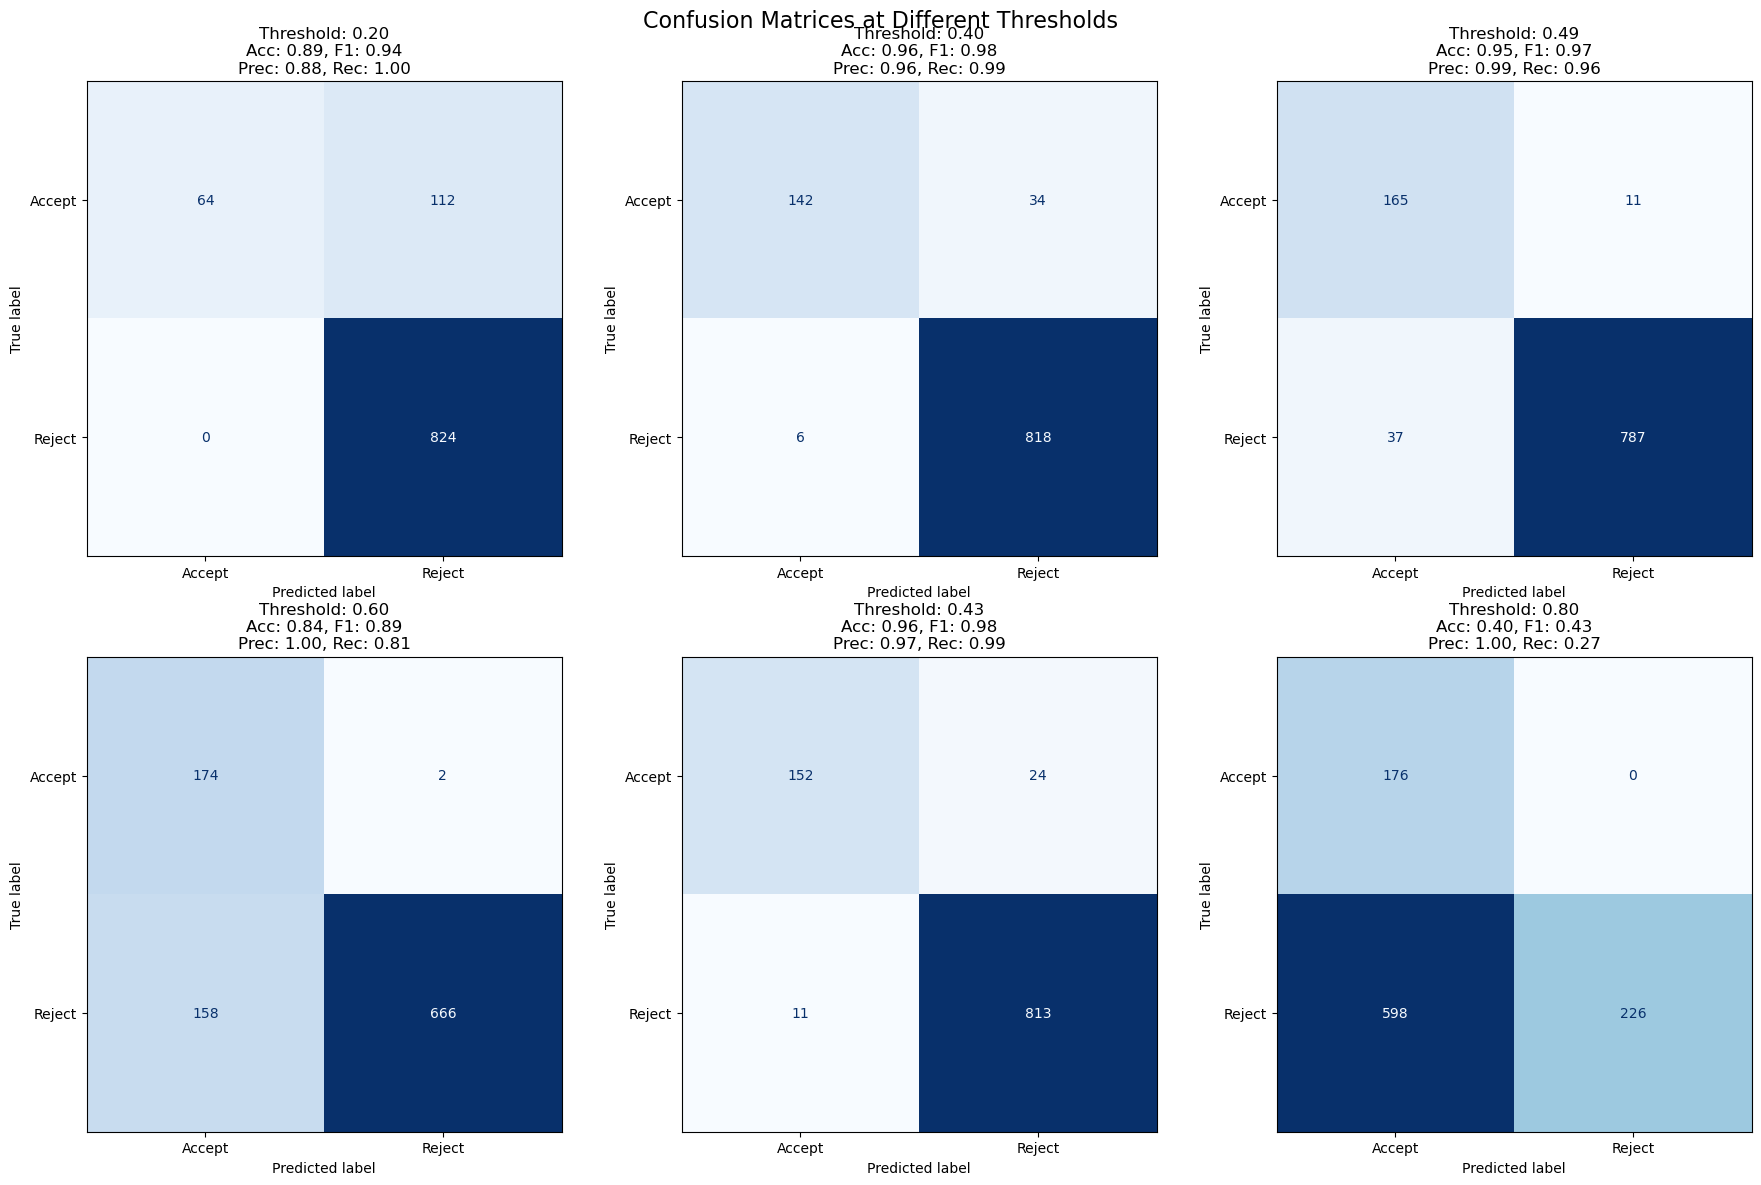

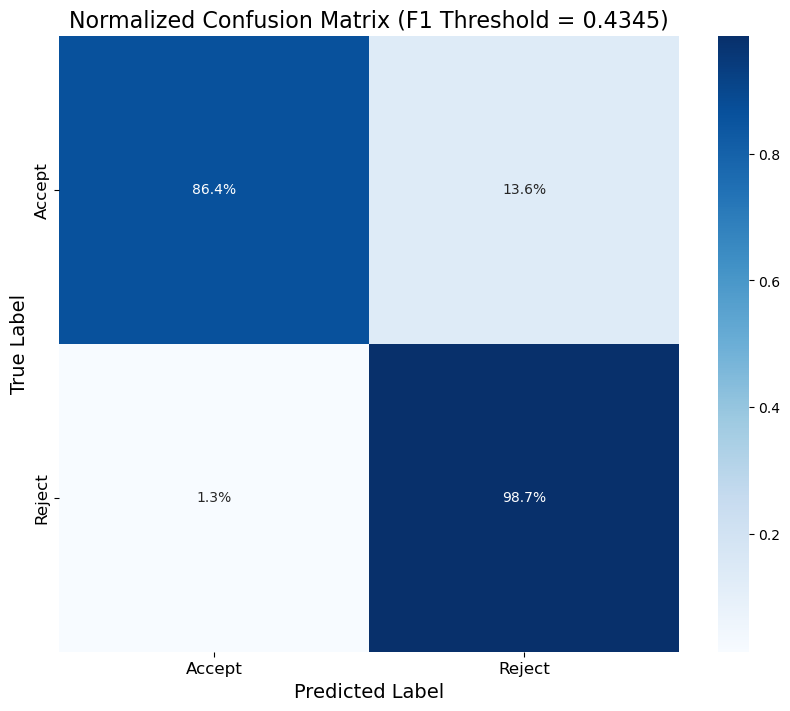

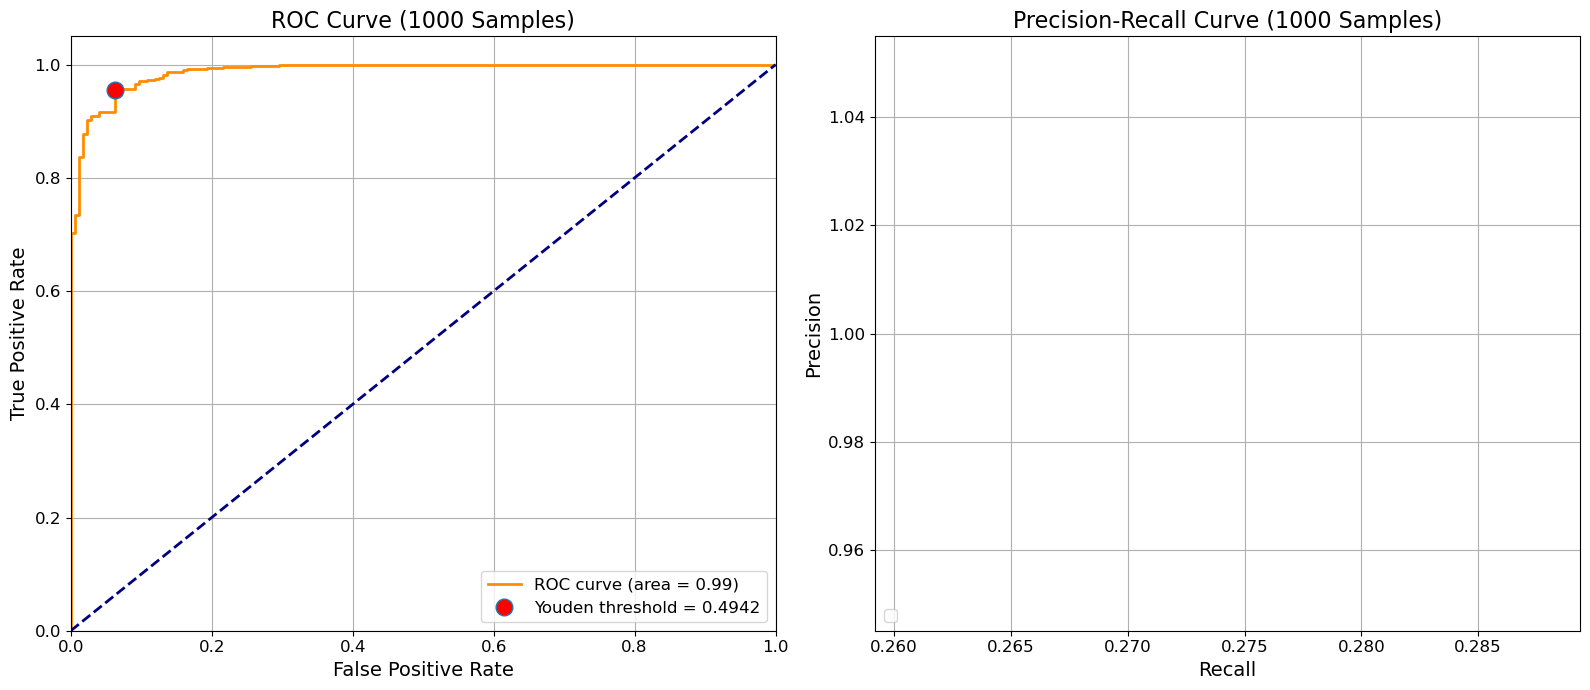

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 1. 导入数据集
# 使用1000个合成样本的数据集
# 从CSV文件加载数据
df = pd.read_csv('synthetic_similarity_data_1000.csv')

# 3. 计算ROC曲线
fpr, tpr, thresholds = roc_curve(df['y_true'], df['orb_similarity'])
roc_auc = auc(fpr, tpr)

# 4. 绘制ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ORB Feature Similarity (1000 Samples)')
plt.legend(loc="lower right")

# 5. 寻找最优阈值 (Youden指数: max(tpr - fpr))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (Youden's Index): {optimal_threshold:.4f}")
print(f"True Positive Rate at this threshold: {tpr[optimal_idx]:.4f}")
print(f"False Positive Rate at this threshold: {fpr[optimal_idx]:.4f}")

# 在ROC曲线上标记最佳点
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', markersize=10, 
         label=f'Best threshold = {optimal_threshold:.4f}', markerfacecolor='red')
plt.legend(loc="lower right")

# 6. 可视化相似度分数分布
plt.figure(figsize=(12, 8))
# 创建分布图
sns.histplot(data=df, x='orb_similarity', hue='y_true', bins=30, kde=True)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Rejection threshold = {optimal_threshold:.4f}')
plt.title('Distribution of Similarity Scores by Decision (Accept/Reject) - 1000 Samples')
plt.xlabel('ORB Similarity')
plt.ylabel('Count')
# 手动创建清晰的图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=sns.color_palette()[0], label='Accept (Not Similar)'),
    Patch(facecolor=sns.color_palette()[1], label='Reject (Similar)'),
    Patch(facecolor='white', edgecolor='red', linestyle='--', label=f'Rejection threshold = {optimal_threshold:.4f}')
]
plt.legend(handles=legend_elements, loc='best')

# 7. 计算精确率-召回率曲线
precision, recall, pr_thresholds = precision_recall_curve(df['y_true'], df['orb_similarity'])
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (1000 Samples)')

# 8. 寻找F1分数最高的阈值
# 注意: precision和recall比pr_thresholds长度多1
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = pr_thresholds[best_f1_idx]
print(f"\nBest threshold based on F1 score: {best_f1_threshold:.4f}")
print(f"F1 score at this threshold: {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at this threshold: {precision[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recall[best_f1_idx]:.4f}")

# 在PR曲线上标记最佳点
plt.plot(recall[best_f1_idx], precision[best_f1_idx], 'o', markersize=10, 
         label=f'Best F1 threshold = {best_f1_threshold:.4f}', markerfacecolor='green')
plt.legend(loc="lower left")

# A. 创建基于两种阈值的混淆矩阵
# Youden阈值的混淆矩阵
plt.figure(figsize=(10, 8))
y_pred_youden = (df['orb_similarity'] >= optimal_threshold).astype(int)
cm_youden = confusion_matrix(df['y_true'], y_pred_youden)
disp_youden = ConfusionMatrixDisplay(confusion_matrix=cm_youden, 
                                     display_labels=["Accept", "Reject"])
disp_youden.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (Youden's Threshold = {optimal_threshold:.4f})")

# F1阈值的混淆矩阵
plt.figure(figsize=(10, 8))
y_pred_f1 = (df['orb_similarity'] >= best_f1_threshold).astype(int)
cm_f1 = confusion_matrix(df['y_true'], y_pred_f1)
disp_f1 = ConfusionMatrixDisplay(confusion_matrix=cm_f1, 
                                 display_labels=["Accept", "Reject"])
disp_f1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (F1 Threshold = {best_f1_threshold:.4f})")

# 添加详细的混淆矩阵，包括百分比和计数
plt.figure(figsize=(12, 10))
y_pred = (df['orb_similarity'] >= best_f1_threshold).astype(int)
cm = confusion_matrix(df['y_true'], y_pred)
# 计算百分比
cm_percent = cm.astype('float') / cm.sum() * 100

# 创建带有计数和百分比的热力图
ax = plt.subplot()
sns.heatmap(cm, annot=np.asarray([
    [f'TN: {cm[0,0]} ({cm_percent[0,0]:.1f}%)', f'FP: {cm[0,1]} ({cm_percent[0,1]:.1f}%)'],
    [f'FN: {cm[1,0]} ({cm_percent[1,0]:.1f}%)', f'TP: {cm[1,1]} ({cm_percent[1,1]:.1f}%)']
]), fmt='', cmap='Blues', xticklabels=["Accept", "Reject"], 
             yticklabels=["Accept", "Reject"])

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Detailed Confusion Matrix (F1 Threshold = {best_f1_threshold:.4f})')

# 混淆矩阵解释
cm_explanation = f"""
Confusion Matrix Explanation:
- True Negatives (TN): {cm[0,0]} - Correctly accepted non-similar images
- False Positives (FP): {cm[0,1]} - Non-similar images wrongly rejected
- False Negatives (FN): {cm[1,0]} - Similar images wrongly accepted
- True Positives (TP): {cm[1,1]} - Correctly rejected similar images

Model Performance:
- Accuracy: {(cm[0,0] + cm[1,1]) / cm.sum():.4f}
- Precision: {cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0:.4f}
- Recall: {cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0:.4f}
- F1 Score: {2 * cm[1,1] / (2 * cm[1,1] + cm[0,1] + cm[1,0]) if (2 * cm[1,1] + cm[0,1] + cm[1,0]) > 0 else 0:.4f}
"""
print(cm_explanation)

# 9. 在不同阈值下可视化性能指标
thresholds_to_test = np.linspace(0, 1, 100)
results = []

for thresh in thresholds_to_test:
    y_pred = (df['orb_similarity'] >= thresh).astype(int)
    tp = sum((df['y_true'] == 1) & (y_pred == 1))
    fp = sum((df['y_true'] == 0) & (y_pred == 1))
    tn = sum((df['y_true'] == 0) & (y_pred == 0))
    fn = sum((df['y_true'] == 1) & (y_pred == 0))
    
    # 避免除零错误
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    results.append({
        'threshold': thresh,
        'true_positive': tp,
        'false_positive': fp,
        'true_negative': tn,
        'false_negative': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    })

metrics_df = pd.DataFrame(results)

# 绘制阈值vs各项指标图
plt.figure(figsize=(12, 8))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], label='F1 Score')
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], label='Accuracy')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Youden threshold = {optimal_threshold:.4f}')
plt.axvline(x=best_f1_threshold, color='green', linestyle='--', label=f'F1 threshold = {best_f1_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Different Thresholds (1000 Samples)')
plt.legend()
plt.grid(True)

# B. 添加多个混淆矩阵图来展示阈值影响
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

thresholds_to_visualize = [0.2, 0.4, optimal_threshold, 0.6, best_f1_threshold, 0.8]
for i, thresh in enumerate(thresholds_to_visualize):
    y_pred_thresh = (df['orb_similarity'] >= thresh).astype(int)
    cm_thresh = confusion_matrix(df['y_true'], y_pred_thresh)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh, display_labels=["Accept", "Reject"])
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[i], colorbar=False)
    
    # 获取该阈值下的模型性能指标
    tn, fp = cm_thresh[0, 0], cm_thresh[0, 1]
    fn, tp = cm_thresh[1, 0], cm_thresh[1, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    axes[i].set_title(f"Threshold: {thresh:.2f}\nAcc: {accuracy:.2f}, F1: {f1:.2f}\nPrec: {precision:.2f}, Rec: {recall:.2f}")

plt.tight_layout()
plt.suptitle("Confusion Matrices at Different Thresholds", fontsize=16)
plt.subplots_adjust(top=0.92)

# 11. 输出推荐的阈值和拒绝图像的解释
print("\nBased on the analysis with 1000 synthetic samples, recommended threshold range for REJECTING similar images:")
print(f"1. Youden's Index threshold: {optimal_threshold:.4f}")
print(f"2. Maximum F1 Score threshold: {best_f1_threshold:.4f}")
print("Images with similarity score >= threshold will be REJECTED (not allowed)")
print("Images with similarity score < threshold will be ACCEPTED (allowed)")

# 打印不同阈值下的性能比较表
print("\nPerformance comparison at different thresholds:")
thresholds_to_show = [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold, best_f1_threshold, 0.7, 0.8, 0.9]
comparison = []
for thresh in thresholds_to_show:
    closest_idx = np.argmin(np.abs(metrics_df['threshold'] - thresh))
    comparison.append(metrics_df.iloc[closest_idx])
comparison_df = pd.DataFrame(comparison)
print(comparison_df[['threshold', 'precision', 'recall', 'f1_score', 'accuracy']].round(4))

# 12. 统计在最佳F1阈值下的误分类
y_pred_best = (df['orb_similarity'] >= best_f1_threshold).astype(int)
df['prediction'] = y_pred_best
df['correct'] = (df['y_true'] == df['prediction']).astype(int)

misclassified = df[df['correct'] == 0]
print(f"\nMisclassified samples: {len(misclassified)} out of {len(df)} ({len(misclassified)/len(df)*100:.2f}%)")

# Count false positives (wrongly rejected) and false negatives (wrongly accepted)
false_positives = df[(df['y_true'] == 0) & (df['prediction'] == 1)]
false_negatives = df[(df['y_true'] == 1) & (df['prediction'] == 0)]

print(f"False positives (non-similar images wrongly rejected): {len(false_positives)} ({len(false_positives)/len(df)*100:.2f}%)")
print(f"False negatives (similar images wrongly accepted): {len(false_negatives)} ({len(false_negatives)/len(df)*100:.2f}%)")

# List problematic similarity scores that lead to errors
print("\nSimilarity score ranges causing misclassifications:")
fp_min, fp_max = false_positives['orb_similarity'].min(), false_positives['orb_similarity'].max()
fn_min, fn_max = false_negatives['orb_similarity'].min(), false_negatives['orb_similarity'].max()

print(f"False positive range: {fp_min:.4f} to {fp_max:.4f}")
print(f"False negative range: {fn_min:.4f} to {fn_max:.4f}")

# Generate normalized confusion matrix (percentages instead of counts)
plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=["Accept", "Reject"], yticklabels=["Accept", "Reject"])
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title(f'Normalized Confusion Matrix (F1 Threshold = {best_f1_threshold:.4f})', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

# Final recommendations
print("\nFINAL RECOMMENDATIONS:")
print(f"Based on the analysis of 1000 synthetic samples, a similarity threshold of {best_f1_threshold:.4f} provides the best balance of precision and recall.")

# 找到最接近best_f1_threshold的阈值索引
closest_idx = np.argmin(np.abs(metrics_df['threshold'] - best_f1_threshold))
best_acc = metrics_df.iloc[closest_idx]['accuracy'] 
best_f1 = metrics_df.iloc[closest_idx]['f1_score']

print(f"This threshold achieves an accuracy of {best_acc:.4f} and an F1 score of {best_f1:.4f}.")
print("\nApplication guidelines:")
print("1. REJECT images with similarity score ≥ {:.4f}".format(best_f1_threshold))
print("2. ACCEPT images with similarity score < {:.4f}".format(best_f1_threshold))
print(f"\nWith these settings, approximately {len(misclassified)/len(df)*100:.1f}% of images may be misclassified:")
print(f"- {len(false_positives)/len(df)*100:.1f}% will be falsely rejected")
print(f"- {len(false_negatives)/len(df)*100:.1f}% will be falsely accepted")

# Create ROC and precision-recall curves with larger font for better visibility
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.set_title('ROC Curve (1000 Samples)', fontsize=16)
ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', markersize=12, 
         label=f'Youden threshold = {optimal_threshold:.4f}', markerfacecolor='red')
ax1.legend(loc="lower right", fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=12)

# PR curve plotting section - fully fixed version that handles both array and scalar cases
# First check if precision and recall are arrays or scalars
ax2.plot(recall, precision, color='blue', lw=2)
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.set_title('Precision-Recall Curve (1000 Samples)', fontsize=16)

# Safely try to mark the best F1 point
try:
    # Check if we have arrays
    if hasattr(recall, '__len__') and hasattr(precision, '__len__') and len(recall) > 1 and len(precision) > 1:
        # Find best F1 score point directly from precision and recall
        f1_values = []
        for i in range(min(len(recall)-1, len(precision)-1)):
            if precision[i] + recall[i] > 0:  # Avoid division by zero
                f1 = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
                f1_values.append((f1, i))
            else:
                f1_values.append((0, i))
        
        if f1_values:
            best_f1, best_idx = max(f1_values)
            if best_idx < min(len(recall), len(precision)):
                ax2.plot(recall[best_idx], precision[best_idx], 'o', markersize=12,
                        label=f'F1 threshold = {best_f1_threshold:.4f}', markerfacecolor='green')
except Exception as e:
    print(f"Warning: Could not plot best F1 point on PR curve: {e}")
    # Just show the curve without the point

ax2.legend(loc="lower left", fontsize=12)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()